Strip AI Kaggle

In [1]:
import time

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import pandas as pd
import cv2 as cv
import tifffile as tifi
from imutils import paths
from pyhere import here

import torch
import torch.nn as nn
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import skimage
from skimage.filters import sobel
from skimage import segmentation
from skimage.measure import regionprops, regionprops_table
from sklearn.preprocessing import StandardScaler
from scipy import ndimage as ndi

First we define the PyTorch model that we will use to extract the features.

In [2]:
class RCF(nn.Module):
    """A model for extracting Random Convolution Features (RCF) from input imagery."""
    def __init__(self, num_features=16, kernel_size=3, num_input_channels=3):
        super(RCF, self).__init__()
        # We create `num_features / 2` filters so require `num_features` to be divisible by 2
        assert num_features % 2 == 0, "Please enter an even number of features."
        # Applies a 2D convolution over an input image composed of several input planes.
        self.conv1 = nn.Conv2d(
            num_input_channels,
            num_features // 2,
            kernel_size=kernel_size,
            stride=1,
            padding=0,
            dilation=1,
            bias=True,
        )
        # Fills the input Tensor 'conv1.weight' with values drawn from the normal distribution
        nn.init.normal_(self.conv1.weight, mean=0.0, std=1.0) 
        # Fills the input Tensor 'conv1.bias' with the value 'val = -1'.
        nn.init.constant_(self.conv1.bias, -1.0)
    def forward(self, x):
        # The rectified linear activation function or ReLU for short is a piecewise linear function 
        # that will output the input directly if it is positive, otherwise, it will output zero.
        x1a = F.relu(self.conv1(x), inplace=True)
        # The below step is where we take the inverse which is appended later
        x1b = F.relu(-self.conv1(x), inplace=True)
        # Applies a 2D adaptive average pooling over an input signal composed of several input planes.
        x1a = F.adaptive_avg_pool2d(x1a, (1, 1)).squeeze()
        x1b = F.adaptive_avg_pool2d(x1b, (1, 1)).squeeze()
        if len(x1a.shape) == 1:  # case where we passed a single input
            return torch.cat((x1a, x1b), dim=0)
        elif len(x1a.shape) == 2:  # case where we passed a batch of > 1 inputs
            return torch.cat((x1a, x1b), dim=1)

In [3]:
torch.cuda.is_available()

True

In [4]:
print(torch.__version__)

1.10.2


Next, we initialize the model and pytorch components

In [5]:
num_features = 4096
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RCF(num_features).eval().to(device)

Read in metadata

In [6]:
train_meta = pd.read_csv(here('data', 'train.csv'))
test_meta = pd.read_csv(here('data', 'test.csv'))
other_meta = pd.read_csv(here('data', 'other.csv'))

List images for training and testing

In [7]:
train_path = here('data', 'train')
train_images = sorted(list(paths.list_images(train_path)))
train_image_ids = [i.split("/")[-1].rstrip('.tif') for i in train_images]

test_path = here('data', 'test')
test_images = sorted(list(paths.list_images(test_path)))
test_image_ids = [i.split("/")[-1].rstrip('.tif') for i in test_images]

Define helper functions

In [8]:
img_to_tensor = T.ToTensor()

In [9]:
def read_tiff(path):
    image = tifi.imread(path)
    filename = path.split('\\')[-1].rstrip('.tif')
    return image, filename

In [10]:
def resize_image(image):
    re_sized_image = (
        cv.resize(
            image,
            (int(image.shape[1]/33),
             int(image.shape[0]/33)),
            interpolation=cv.INTER_LINEAR))
    return re_sized_image

In [11]:
def convert_image_grayscale(image):
    gray_image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
    return gray_image

In [12]:
def segment_images(resized_gray_img):
    elevation_map = sobel(resized_gray_img)
    markers = np.zeros_like(resized_gray_img)
    markers[resized_gray_img >= resized_gray_img.mean()] = 1
    markers[resized_gray_img < resized_gray_img.mean()] = 2
    segmented_img = segmentation.watershed(elevation_map, markers)
    filled_segments = ndi.binary_fill_holes(segmented_img - 1)
    labeled_segments, _ = ndi.label(filled_segments)
    return labeled_segments

In [13]:
def get_object_coordinates(labeled_segments):
    properties = ['area','bbox','convex_area','bbox_area', 'major_axis_length', 'minor_axis_length', 'eccentricity']
    df = pd.DataFrame(regionprops_table(labeled_segments, properties=properties))
    standard_scaler = StandardScaler()
    scaled_area = standard_scaler.fit_transform(df.area.values.reshape(-1,1))
    df['scaled_area'] = scaled_area
    df.sort_values(by="scaled_area", ascending=False, inplace=True)
    objects = df[df['scaled_area']>=.75]
    object_coordinates = [
        (int(row['bbox-0']),
         int(row['bbox-1']),
         int(row['bbox-2']),
         int(row['bbox-3']) )
        for index, row in objects.iterrows()
    ]
    return object_coordinates
def crop_patch(coordinates, image):
    x1, y1, x2, y2 = coordinates
    cropped_image = image[x1:x2, y1:y2]
    return cropped_image

Open file, resize, convert to grayscale, segment, crop, and featurize. 

In [14]:
%%time
tic = time.time()
j = 0
image_patches = []
features = []
for tif in train_images[1:5]:
    image, filename = read_tiff(tif)
    re_sized_image = resize_image(image)
    resized_gray_img = convert_image_grayscale(re_sized_image)
    labeled_segments = segment_images(resized_gray_img)
    object_coordinates = get_object_coordinates(labeled_segments)
    for i in range(len(object_coordinates)):
        patch_name = str(filename)+"_"+str(i+1)
        # print(patch_name)
        coordinates = object_coordinates[i]
        cropped_image = crop_patch(coordinates, image)
        tensor = img_to_tensor(cropped_image)
        tensor = tensor.to(device)
        with torch.no_grad():
            feats = model(tensor.unsqueeze(0)).cpu().numpy()
        features.append(feats)
        image_patches.append(patch_name)
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
    if j % 50 == 0:
        print(f"{j}/{len(train_images)} -- {j / len(train_images) * 100:0.2f}% -- {time.time()-tic:0.2f} seconds")
        tic = time.time()
    j += 1

0/754 -- 0.00% -- 12.13 seconds
CPU times: total: 51.1 s
Wall time: 1min 40s


In [15]:
data = (
    pd.DataFrame(features, image_patches)
    .rename_axis('image_patch')
    .reset_index()
)
data

,image_patch,0,1,2,3,4,5,6,7,8,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,008e5c_0_1,0.000000,0.0,0.000000,0.000000,0.0,1.145914,12.608255,1.416052,0.0,...,0.871516,5.940131,3.410650,3.559596,0.0,7.259597,0.000000,6.353465,2.593402,1.236473
1,008e5c_0_2,0.000000,0.0,0.000000,0.000000,0.0,1.145914,12.608255,1.416052,0.0,...,0.871516,5.940132,3.410650,3.559596,0.0,7.259597,0.000000,6.353465,2.593402,1.236473
2,00c058_0_1,0.000000,0.0,0.000000,0.000000,0.0,1.221874,12.482499,1.433200,0.0,...,0.797054,5.710192,3.493395,3.372087,0.0,7.004998,0.000004,6.635960,2.516577,1.171401
3,00c058_0_2,0.000000,0.0,0.000000,0.000000,0.0,1.221897,12.482594,1.433222,0.0,...,0.797047,5.710218,3.493421,3.372096,0.0,7.005036,0.000000,6.636027,2.516589,1.171402
4,00c058_0_3,0.000000,0.0,0.000000,0.000000,0.0,1.221898,12.482591,1.433222,0.0,...,0.797047,5.710218,3.493420,3.372097,0.0,7.005038,0.000000,6.636025,2.516589,1.171402
5,00c058_0_4,0.000000,0.0,0.000000,0.000000,0.0,1.221898,12.482591,1.433222,0.0,...,0.797047,5.710217,3.493420,3.372097,0.0,7.005037,0.000000,6.636024,2.516588,1.171402
6,00c058_0_5,0.000000,0.0,0.000000,0.000000,0.0,1.221898,12.482592,1.433222,0.0,...,0.797047,5.710217,3.493420,3.372097,0.0,7.005039,0.000000,6.636025,2.516589,1.171402
7,00c058_0_6,0.000000,0.0,0.000000,0.000000,0.0,1.221898,12.482591,1.433222,0.0,...,0.797047,5.710217,3.493420,3.372097,0.0,7.005038,0.000000,6.636025,2.516588,1.171402
8,00c058_0_7,0.000000,0.0,0.000000,0.000000,0.0,1.221898,12.482592,1.433222,0.0,...,0.797047,5.710217,3.493420,3.372097,0.0,7.005038,0.000000,6.636026,2.516589,1.171402
9,00c058_0_8,0.000000,0.0,0.000000,0.000000,0.0,1.221898,12.482600,1.433222,0.0,...,0.797047,5.710215,3.493422,3.372097,0.0,7.005035,0.000000,6.636024,2.516587,1.171402


<AxesSubplot:>

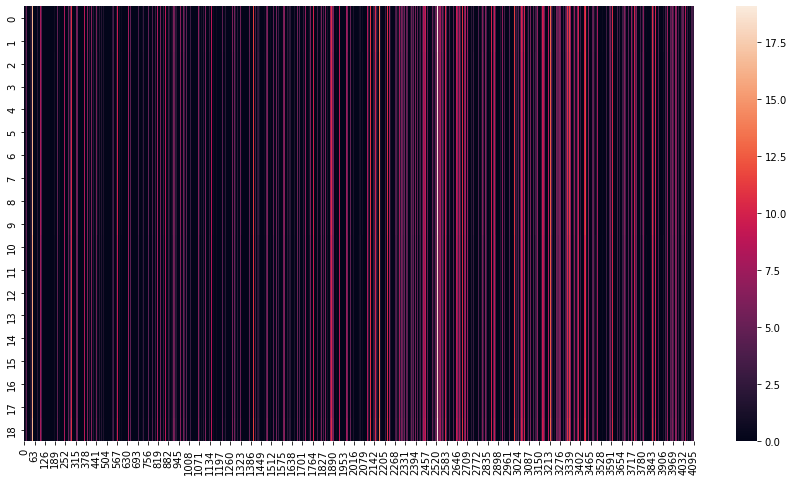

In [24]:
import seaborn as sns
plt.figure(figsize = (15,8))
sns.heatmap(data.iloc[:,1:])